In [1]:
import pandas as pd
import sys
import os
sys.path.insert(0, '../../../')

from notebooks.utils import _ALEXA_DATA_PATH, load_node_features, load_level_data, create_overlap_nodes, export_model_as_feature
from train import run_experiment

2022-01-12 11:52:28.935664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load audience overlap edges for level 1

In [2]:
level = 1
audience_overlap_sites = load_level_data(os.path.join(_ALEXA_DATA_PATH, 'corpus_2018_audience_overlap_sites_scrapping_result.json'), level=level)
audience_overlap_sites_NODES = create_overlap_nodes(audience_overlap_sites)

print(audience_overlap_sites_NODES[:5])

01-12 11:52:31 notebooks.utils INFO     Loaded 4238 nodes with records level <= 1 and child size:20335


[('villagevoice.com', 'nylon.com'), ('villagevoice.com', 'slantmagazine.com'), ('villagevoice.com', 'gothamist.com'), ('villagevoice.com', 'screendaily.com'), ('villagevoice.com', 'amny.com')]


In [3]:
edge_df = pd.DataFrame(audience_overlap_sites_NODES, columns=['source', 'target'])

edge_df.head()

,source,target
0,villagevoice.com,nylon.com
1,villagevoice.com,slantmagazine.com
2,villagevoice.com,gothamist.com
3,villagevoice.com,screendaily.com
4,villagevoice.com,amny.com


### Find all unique nodes in edges

In [4]:
nodes_in_edges = list(set(edge_df.source.unique().tolist() + edge_df.target.unique().tolist()))
print('Number of unique nodes in edges:', len(nodes_in_edges), 'Sample:', nodes_in_edges[:5])

Number of unique nodes in edges: 11865 Sample: ['fidanoski.ca', 'thebluewave.net', 'evonomics.com', 'defenseone.com', 'acronym.org.uk']


### 1. Load all node features

In [5]:
node_features_df = load_node_features()
node_features_df = node_features_df.set_index('site')
node_features_df.head()

,alexa_rank,daily_pageviews_per_visitor,daily_time_on_site,total_sites_linking_in,bounce_rate
site,,,,,
whistleblowersandrelators.com,NaN,NaN,NaN,NaN,NaN
geokov.com,2238341.0,1.0,NaN,60.0,0.900
trainingandfacilitation.ca,NaN,NaN,NaN,NaN,NaN
plumsolutions.com.au,1023533.0,1.0,138.0,60.0,0.813
dbdailyupdate.com,145283.0,1.7,179.0,64.0,0.756


# Subset node_features

In [6]:
node_features_df = node_features_df.loc[nodes_in_edges]

In [7]:
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11865 entries, fidanoski.ca to infidels.org
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   alexa_rank                   8657 non-null   float64
 1   daily_pageviews_per_visitor  8658 non-null   float64
 2   daily_time_on_site           6458 non-null   float64
 3   total_sites_linking_in       11469 non-null  float64
 4   bounce_rate                  6022 non-null   float64
dtypes: float64(5)
memory usage: 556.2+ KB


### 2. Fill all missing alexa_rank and total_sites_linking_in with 0 

In [8]:
node_features_df.alexa_rank = node_features_df.alexa_rank.fillna(0)
node_features_df.total_sites_linking_in = node_features_df.total_sites_linking_in.fillna(0)
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11865 entries, fidanoski.ca to infidels.org
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   alexa_rank                   11865 non-null  float64
 1   daily_pageviews_per_visitor  8658 non-null   float64
 2   daily_time_on_site           6458 non-null   float64
 3   total_sites_linking_in       11865 non-null  float64
 4   bounce_rate                  6022 non-null   float64
dtypes: float64(5)
memory usage: 556.2+ KB


### 3. Normalizing features

In [9]:
import math

node_features_df['normalized_alexa_rank'] = node_features_df['alexa_rank'].apply(lambda x: 1/x if x else 0)
node_features_df['normalized_total_sites_linked_in'] = node_features_df['total_sites_linking_in'].apply(lambda x: math.log2(x) if x else 0)

# Create Graph

In [10]:
import stellargraph as sg

G = sg.StellarGraph(node_features_df[['normalized_alexa_rank', 'normalized_total_sites_linked_in']], edge_df)

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 11865, Edges: 20399

 Node types:
  default: [11865]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [20399]
        Weights: all 1 (default)
        Features: none


# Unsupervised Deep Graph Infomax

In [11]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator
)
from stellargraph.layer import GCN, DeepGraphInfomax

from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

nodes = list(G.nodes())
number_of_walks = 1
length = 5

# 2. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

# 3. Create a node pair generator:

infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

deep_graph_infomax_model = Model(inputs=x_in, outputs=x_out)
deep_graph_infomax_model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))


Using GCN (local pooling) filters...


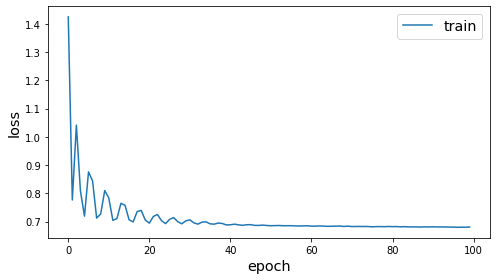

In [12]:
from stellargraph.utils import plot_history

epochs = 100

es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = deep_graph_infomax_model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

node_features_fullbactch_generator = fullbatch_generator.flow(node_features_df.index)
node_embeddings = emb_model.predict(node_features_fullbactch_generator)

embeddings_wv = dict(zip(node_features_df.index.tolist(), node_embeddings.tolist()))

# print('Sample:', embeddings_wv['crooked.com'][:10])

# Export embeddings as feature

In [13]:
export_model_as_feature(embeddings_wv, f'deep_graph_infomax_level_{level}_epochs_{epochs}', data_year='2018')

'/Users/panayot/Documents/News-Media-Peers/data/emnlp2018/features/deep_graph_infomax_level_1_epochs_100.json'

In [14]:
run_experiment(features=f'deep_graph_infomax_level_{level}_epochs_{epochs}', dataset='emnlp2018')

+------+---------------------+---------------+--------------------+---------------------------------------+
| task | classification_mode | type_training | normalize_features |                features               |
+------+---------------------+---------------+--------------------+---------------------------------------+
| fact |  single classifier  |    combine    |        True        | deep_graph_infomax_level_1_epochs_100 |
+------+---------------------+---------------+--------------------+---------------------------------------+


01-12 11:53:29 train        INFO     Start training...
01-12 11:53:29 train        INFO     Fold: 0
01-12 11:53:35 train        INFO     Fold: 1
01-12 11:53:41 train        INFO     Fold: 2
01-12 11:53:46 train        INFO     Fold: 3
01-12 11:53:51 train        INFO     Fold: 4


+------+---------------------+---------------+--------------------+---------------------------------------+-------------------+-------------------+--------------------+--------------------+
| task | classification_mode | type_training | normalize_features |                features               |      Macro-F1     |      Accuracy     |  Flip error-rate   |        MAE         |
+------+---------------------+---------------+--------------------+---------------------------------------+-------------------+-------------------+--------------------+--------------------+
| fact |  single classifier  |    combine    |        True        | deep_graph_infomax_level_1_epochs_100 | 44.92546928807912 | 59.75494816211122 | 14.326107445805844 | 0.5457115928369463 |
+------+---------------------+---------------+--------------------+---------------------------------------+-------------------+-------------------+--------------------+--------------------+


In [15]:
run_experiment(features=f'deep_graph_infomax_level_{level}_epochs_{epochs}', dataset='emnlp2018', task='bias')

+------+---------------------+---------------+--------------------+---------------------------------------+
| task | classification_mode | type_training | normalize_features |                features               |
+------+---------------------+---------------+--------------------+---------------------------------------+
| bias |  single classifier  |    combine    |        True        | deep_graph_infomax_level_1_epochs_100 |
+------+---------------------+---------------+--------------------+---------------------------------------+


01-12 11:53:58 train        INFO     Start training...
01-12 11:53:58 train        INFO     Fold: 0
01-12 11:54:05 train        INFO     Fold: 1
01-12 11:54:11 train        INFO     Fold: 2
01-12 11:54:22 train        INFO     Fold: 3
01-12 11:54:32 train        INFO     Fold: 4


+------+---------------------+---------------+--------------------+---------------------------------------+-------------------+-------------------+-------------------+--------------------+
| task | classification_mode | type_training | normalize_features |                features               |      Macro-F1     |      Accuracy     |  Flip error-rate  |        MAE         |
+------+---------------------+---------------+--------------------+---------------------------------------+-------------------+-------------------+-------------------+--------------------+
| bias |  single classifier  |    combine    |        True        | deep_graph_infomax_level_1_epochs_100 | 40.89723856864146 | 57.21017907634307 | 7.445805843543826 | 0.5023562676720076 |
+------+---------------------+---------------+--------------------+---------------------------------------+-------------------+-------------------+-------------------+--------------------+
